# Assignment 4

CS4442 Aritificial Intelligence II

Michael Tran

## Step 1
Use one of the deep learning frameworks (Pytorch, Tensorflow, Keras, ...) and load the pre-trained AlexNet model. Input these 156 images to the pre-trained AlexNet model and extract feature maps/activations from Conv 1, 2, 3, 4, 5, fc6, and fc7 layers. Vectorize the activations corresponding to each image. You should have a vector of activations per image per layer mentioned above. (20 points)

In [79]:
# Load imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from matplotlib.colors import ListedColormap
from PIL import Image
from sklearn.manifold import MDS
from torchvision import transforms
from torchvision.models import AlexNet_Weights


In [80]:
# Load pre-trained AlexNet
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)

# Define transformation for the input images
transformer = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)


In [81]:
# Load the input images and preprocess them using the transformer
input_images = []

for i in range(1, 157):
    img_path = "./Image Set/{:03d}.jpg".format(i)
    img = Image.open(img_path)
    preprocessed_img = transformer(img)
    input_images.append(preprocessed_img)


In [82]:
# Convert the input images into a batch and feed it to the model
input_batch = torch.stack(input_images)

with torch.no_grad():
    outputs = alexnet(input_batch)


In [83]:
# Extract feature maps/activations from Conv 1, 2, 3, 4, 5, fc6, and fc7 layers
activations = {}
x = input_batch
for name, module in alexnet.features._modules.items():
    x = module(x)
    if name in ["0", "3", "6", "8", "10"]:
        activations[name] = x

x = x.view(x.size(0), -1)
for name, module in alexnet.classifier._modules.items():
    x = module(x)
    if name in ["0", "3"]:
        activations[name] = x

# Add activations for fc6, fc7
fc6_activation = alexnet.classifier[0](x)
fc7_activation = alexnet.classifier[3](fc6_activation)
activations["fc6"] = fc6_activation
activations["fc7"] = fc7_activation

# Vectorize each of the activations tensors
for layer_name, tensor in activations.items():
    layer_activation = tensor.detach().numpy().reshape(tensor.shape[0], -1)
    activations[layer_name] = layer_activation


## Step 2
Create a representational dissimilarity matrix (RDM) which is 156 x156 matrix, each row and column in this matrix is indexed by one of the images in the image set and each element in the matrix is the Euclidean distance between the activation vectors of the corresponding images you extracted in Step 1. (30 points)

In [84]:
RDMs = []
for layer_name, layer_activation in activations.items():
    # compute the RDM for each layer
    layer_RDM = 1 - np.corrcoef(layer_activation)
    RDMs.append(layer_RDM)


## Step 3
Plot the RDM for each layer (Conv 1, 2, 3, 4, 5, fc6, fc7), and their corresponding multidimensional scaling (MDS) visualization in 2 Dimension. The class labels you should use for the MDS plotting includes images 1 to 28 are Animals, 29-64 are Objects, 65 to 100 are scenes, 101 to 124 are human activities, 125 to 156 are faces. (30 points)

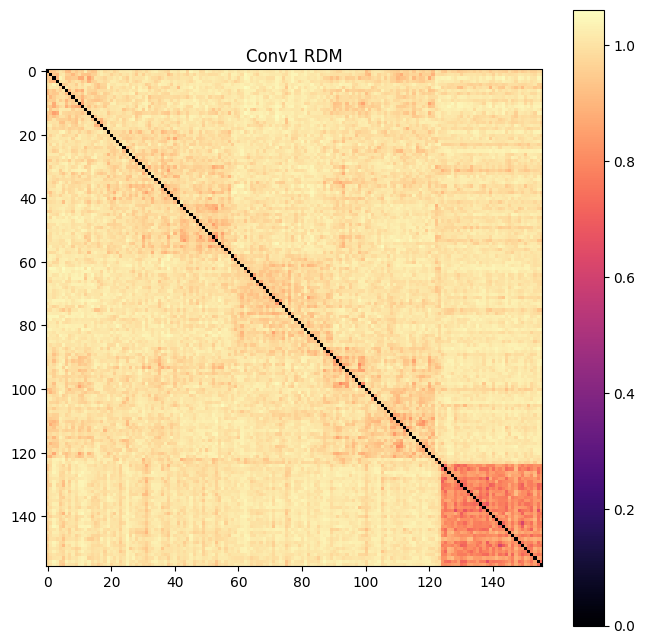

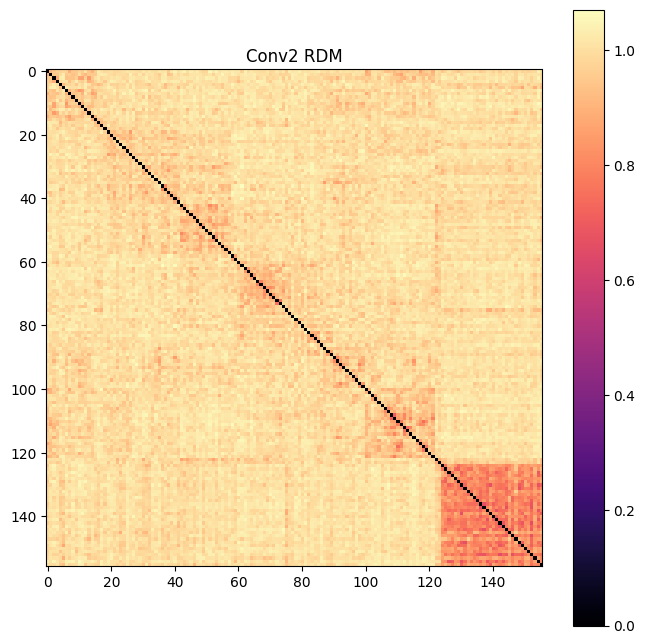

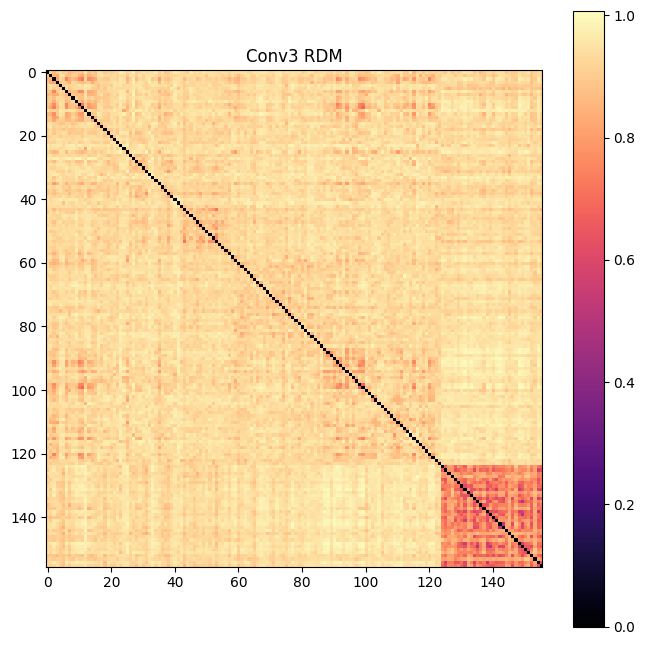

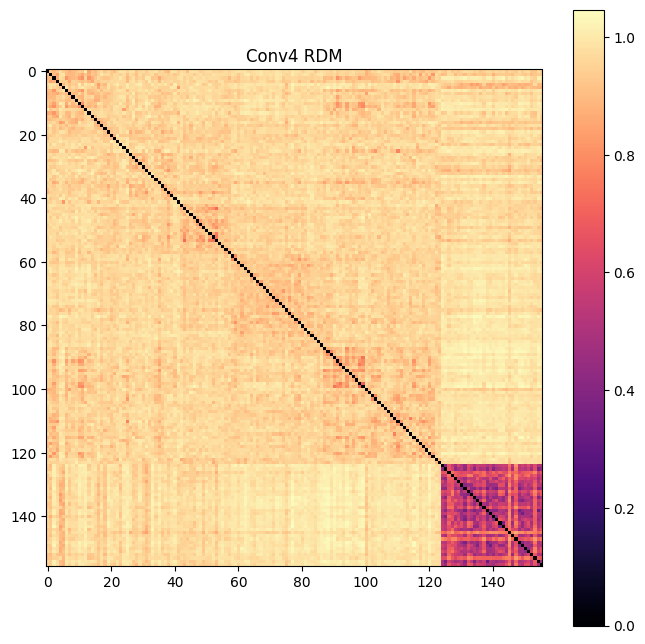

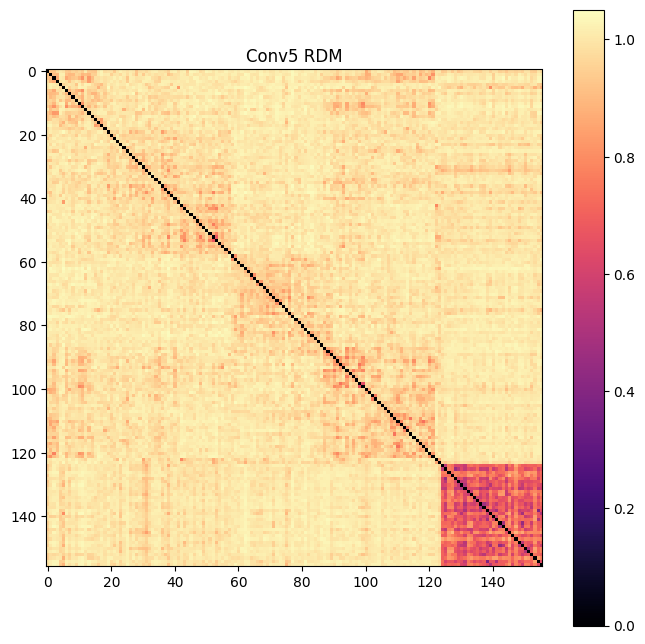

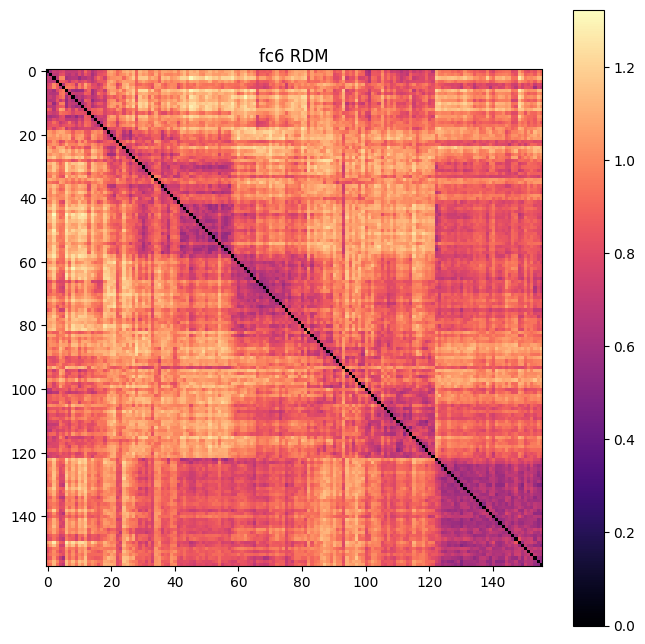

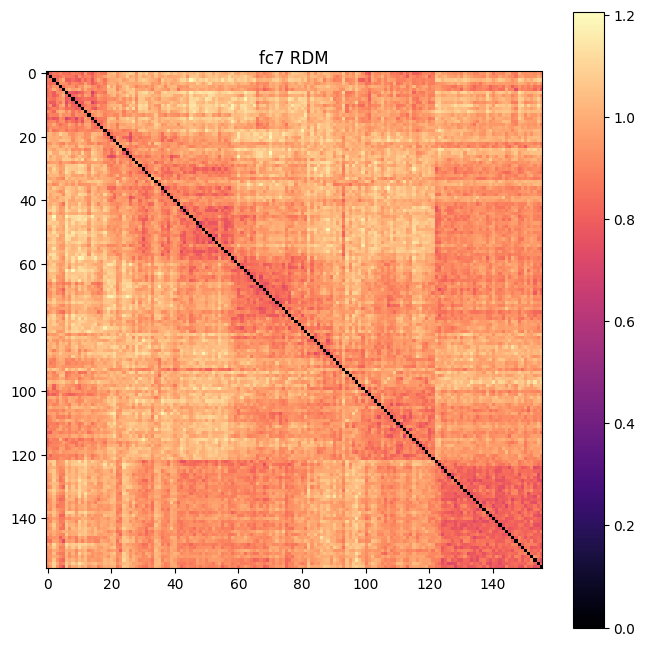

In [85]:
# define a list of layer names to use for plotting
layer_names = ["Conv1", "Conv2", "Conv3", "Conv4", "Conv5", "fc6", "fc7"]

# plot the RDMs for each layer
for i, layer_name in enumerate(layer_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(RDMs[i], cmap="magma")
    plt.title(f"{layer_name} RDM")
    plt.colorbar()
    plt.show()


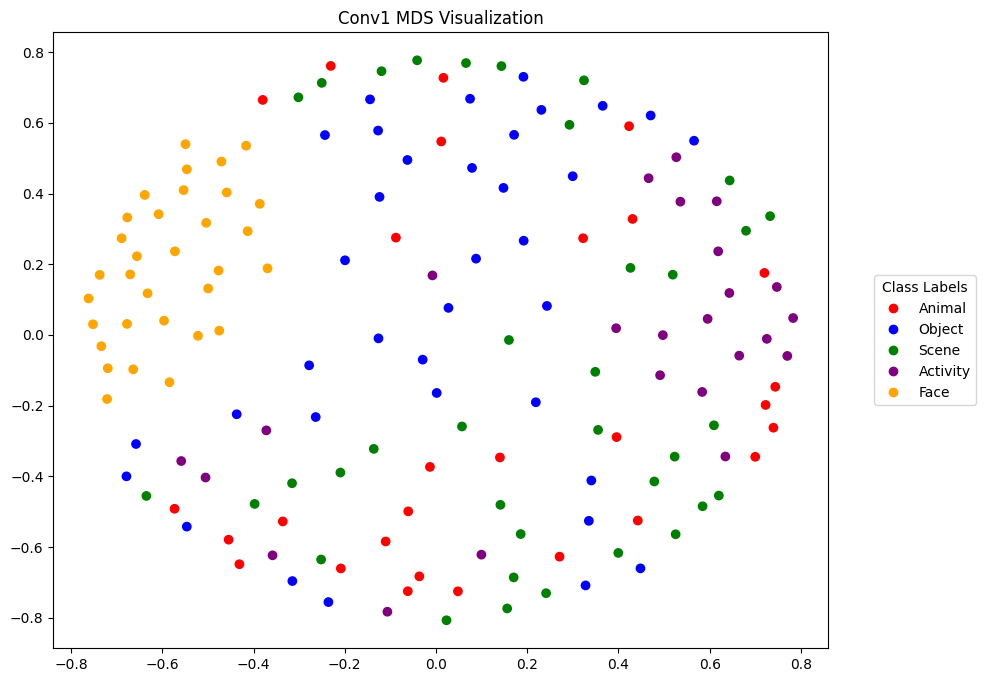

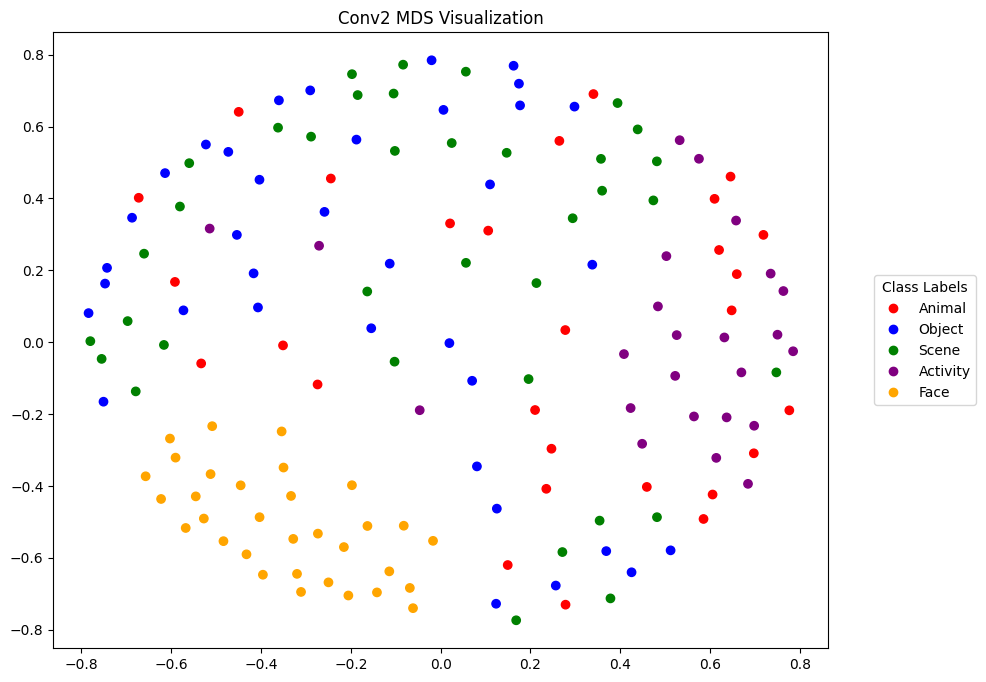

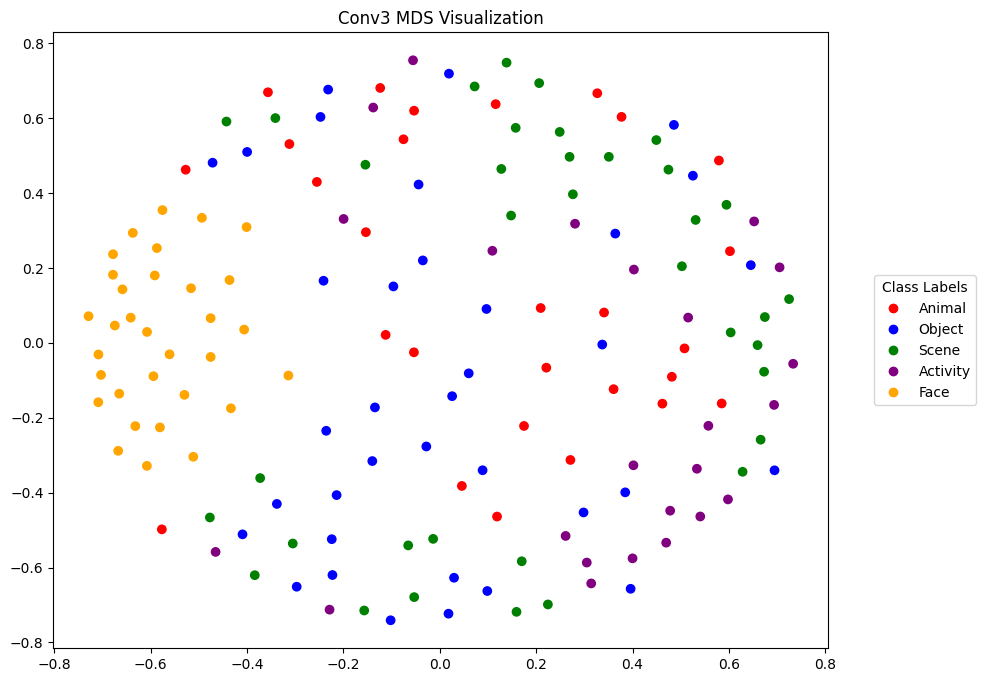

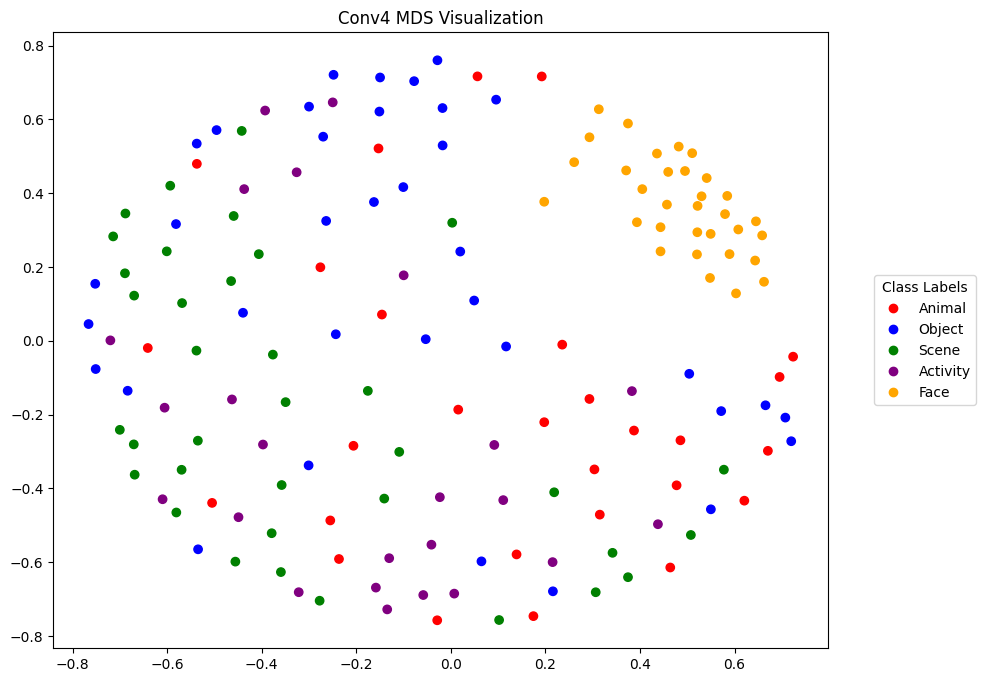

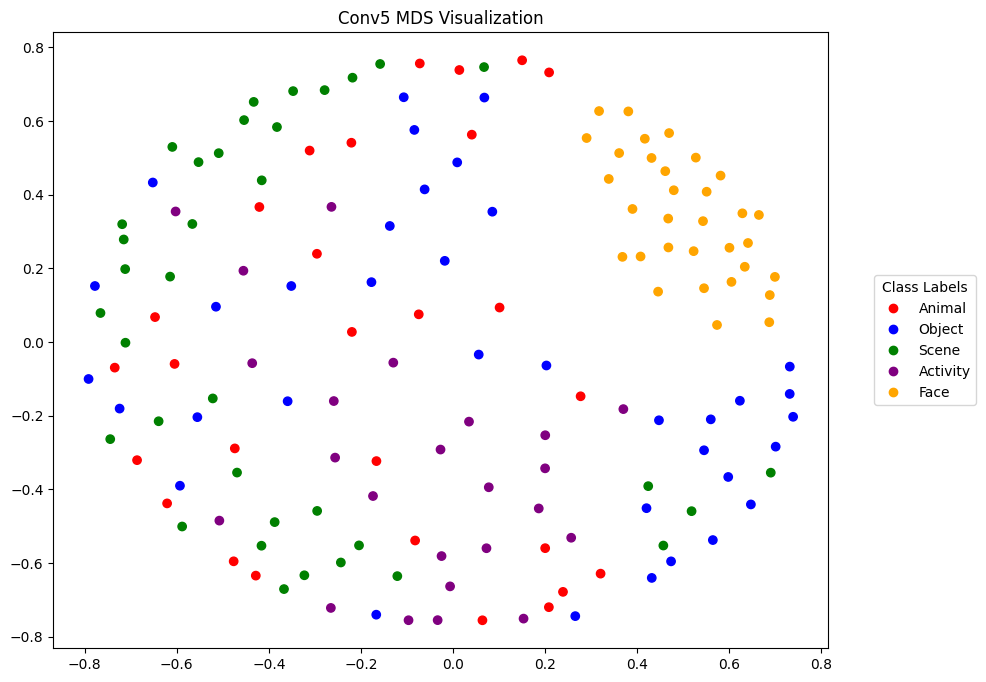

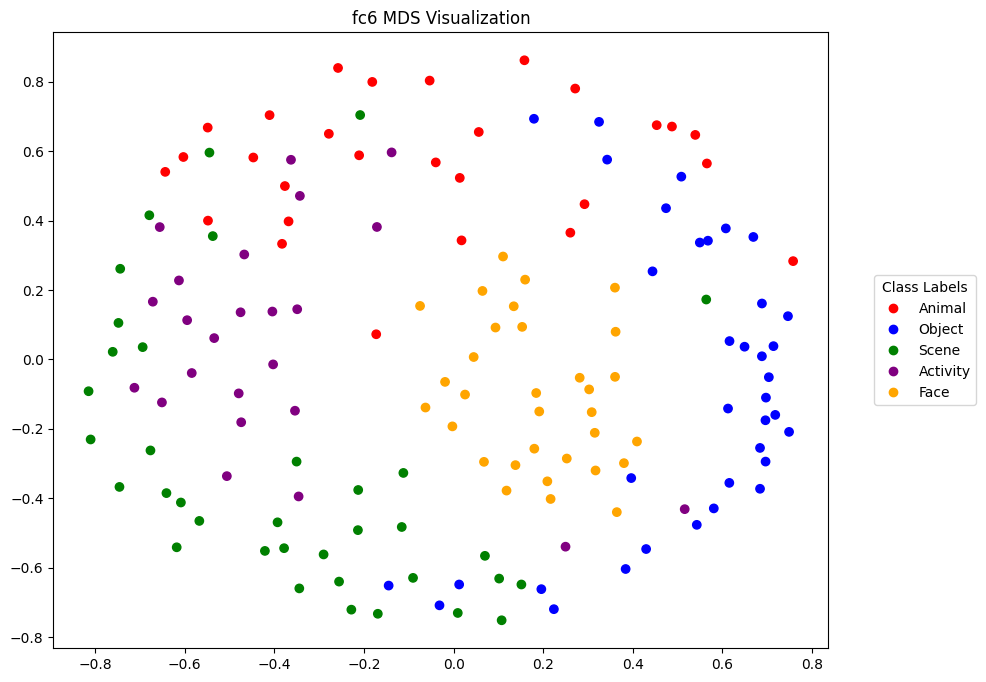

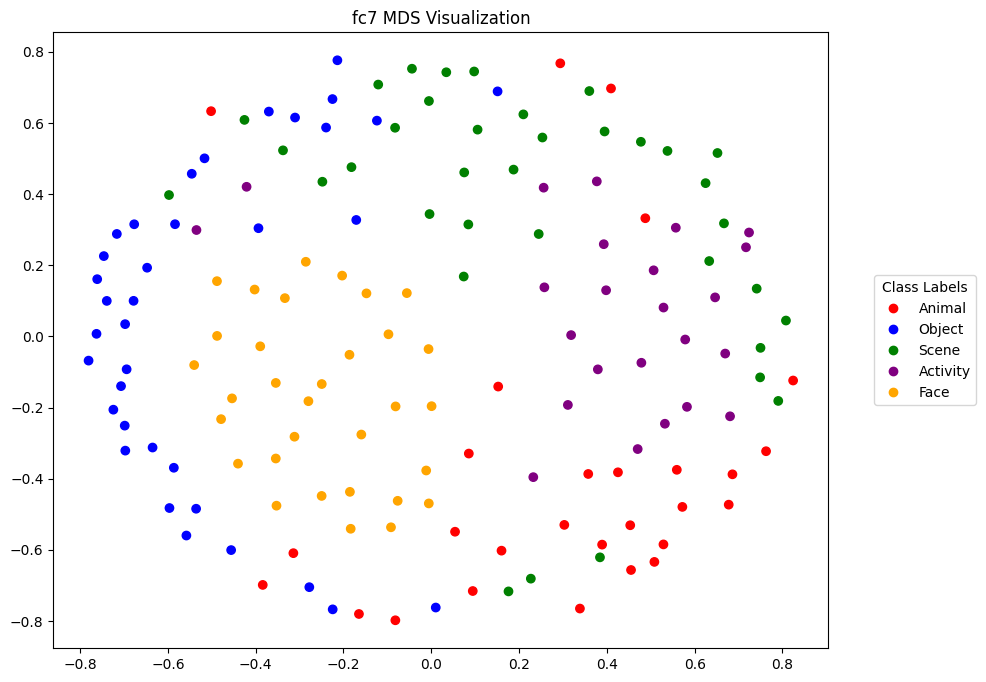

In [86]:
# RDM is a 156x156 numpy array containing the RDM for each layer

# define class labels for each image
class_labels = (
    ["Animal"] * 28
    + ["Object"] * 36
    + ["Scene"] * 36
    + ["Activity"] * 24
    + ["Face"] * 32
)

# Define colors for each class label
colors = {
    "Animal": "red",
    "Object": "blue",
    "Scene": "green",
    "Activity": "purple",
    "Face": "orange",
}

# Define colour mapping (to integer values)
class_colors = [colors[label] for label in class_labels]
cmap = ListedColormap(class_colors, len(set(class_labels)))
class_mapping = {
    "Animal": 0,
    "Object": 1,
    "Scene": 2,
    "Activity": 3,
    "Face": 4,
}
class_labels_int = [class_mapping[label] for label in class_labels]

# create a plot for each layer
for i, layer_name in enumerate(layer_names):
    # apply MDS to the RDM to obtain 2D coordinates for each image
    embedding = MDS(
        n_components=2, dissimilarity="precomputed", normalized_stress=False
    ).fit_transform(RDMs[i])

    # plot the 2D coordinates using class labels for color coding
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        embedding[:, 0], embedding[:, 1], c=class_labels_int, cmap=cmap
    )
    plt.title(f"{layer_name} MDS Visualization")

    # create a custom legend with the class labels
    handles, labels = scatter.legend_elements()
    legend_labels = [
        list(class_mapping.keys())[
            list(class_mapping.values()).index(
                int(label.strip("$\\mathdefault{}$"))
            )
        ]
        for label in labels
    ]
    # move legend to right of plot
    legend = ax.legend(
        handles,
        legend_labels,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        title="Class Labels",
    )

    plt.show()


### Please write a short report presenting and discussing the results of this assignment. (20 points)

Introduction

In this assignment, I inputted 156 different images of JPEG format into the pre-trained AlexNet model in order to map and visualize the image recognition of the labels (Animal, Object, Scene, Activity, Face). The AlexNet model was developed by Krizhevsky et al in 2012 as part of the ImageNet challenge to implement object recognition models. It is a convolutional neural network (CNN) consisting of five convolutional layers as well as additional fully connected layers for classification. The input dataset consists of 156 JPEG images of varying dimensions, in order of their respective class labels: 28 Animal, 36 Object, 36 Scene, 24 Activity, and 32 Face.

Methods

To access the pre-trained AlexNet model and work with a deep learning models, I used the `PyTorch` deep learning framework, an open source library available in Python developed by Facebook's AI research team. PyTorch has pre-trained models available and accessible within the package, including AlexNet pre-trained with weights. I imported this and also prepared a transformer to take in the varying JPEG inputs and transform them to the standard ImageNet specifications. This involves resizing them to the correct image dimensions taken by the model, 227 x 227 pixels, and normalizing the pixel values to the mean and standard deviation of the ImageNet dataset. Next I looped over each of my input images, loaded them into Python using the `PIL` package, and applied my transformer to each of them. Now that I had my batch of images, I could feed them to the model.

From the results I extracted feature maps / activations from each of the layers Conv1, Conv2, Conv3, Conv4, Conv5, fc6, and fc7. I stored these activations in a dictionary named `activations` and vectorized each of them. I also created a representational dissimilarity matrix (RDM) named `RDMs` from the vectors that represents the Euclidian distances between them.

Results

Using the `matplotlib` library in Python, I plotted my results from the model, beginning with the RDM matrix. I generated RDM plots of each of the layers mentioned previously. This gave me seven RDM plots, representing the similarity betwwen the images in each layer of the CNN. Using the colour scale, we can observe pairwise similarities between the inputs. Along the diagonal is a noticable black line, and this is because when comparing an image to itself, it is expected that there is zero dissimilarity. Using the colour scale, I can observe a high level of dissimilarity between images as the plots seem to be generally light in colour, which corresponds to a high disimilarity. There is a noticeable exception to this in the bottom right corner, where the last subset of images show a darker square, representing a closer similarity to each other. The last subset of images in the input dataset represents the group Faces, so it is interesting to observe that these images are relatively closer to one another than the rest of the images. Otherwise, we can also see slight clustering of class labels through colour differences, creating a faint checkered-like pattern. Each of the squares would represent a class label, as naturally images belonging to the same group are expected to have a similar level of closeness to one another than with other groups. As we plot more layers, the RDM plots show overall less dissimilarity.

Next, I plotted the results of the model using Multidimenional Scaling (MDS) in order to visualize and compare the similarity between images of the CNN. By plotting for each layer, I could explore how the MDS representations change as they are processed through each layer of the CNN. The overall trend seen through the resulting plots is that each layer had distict patterns, with the first layers likely grouping based on low-level features whilst the latter layers group based on high-level semantic features corresponding to the categories, i.e. Animals, Scenes, Faces, etc. Looking at the colour legend, we can see that the clustering of group improves with each layer, where images of the same class label are closer to one another. In particular, the cluster corresponding to the Face label are very tightly clustered even from the first layer. This complements our findings from the RDM plots, where we noticed that the Face images have a relatively higher similarity to one another compared to the rest of the images. We can even see this cluster form a slight gap between itself and the rest of the images in the MDS plots, highlighting their difference as a group.

Conclusion

Overall, the results of the assignment provide insight on how images are processed in a convolutional neural network, namely AlexNet. By visualizing the similarity between images in different layers, we gain a better understanding of how the network classifies and recognizes different groups such as objects, scenes, or faces. We also explore how different class labels of images compare to one another in similarity and image recognition efficiency.